In [1]:
import utils
from utils import *
from resnet50 import *



%matplotlib inline
from sys import getsizeof

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is enabled with initial size: 75.0% of memory, cuDNN 5103)


In [2]:
target_size = (100,100)#(256, 256)

In [3]:
K.set_image_data_format('channels_first')
K.image_data_format()

'channels_first'

### Load Data

In [4]:
x_train = []
y_train = []

df_train = pd.read_csv('data/train_v2.csv')
df_test = pd.read_csv('data/sample_submission_v2.csv')

flatten = lambda l: [item for sublist in l for item in sublist]
labels = list(set(flatten([l.split(' ') for l in df_train['tags'].values])))

labels = ['blow_down',
 'bare_ground',
 'conventional_mine',
 'blooming',
 'cultivation',
 'artisinal_mine',
 'haze',
 'primary',
 'slash_burn',
 'habitation',
 'clear',
 'road',
 'selective_logging',
 'partly_cloudy',
 'agriculture',
 'water',
 'cloudy']

label_map = {'agriculture': 14,
 'artisinal_mine': 5,
 'bare_ground': 1,
 'blooming': 3,
 'blow_down': 0,
 'clear': 10,
 'cloudy': 16,
 'conventional_mine': 2,
 'cultivation': 4,
 'habitation': 9,
 'haze': 6,
 'partly_cloudy': 13,
 'primary': 7,
 'road': 11,
 'selective_logging': 12,
 'slash_burn': 8,
 'water': 15}

In [5]:
train_gen = image.ImageDataGenerator( 
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    channel_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True)

### Load JPEG files

In [6]:

# for f, tags in tqdm(df_train.values, miniters=1000):
#     img = cv2.imread('data/train-jpg/{}.jpg'.format(f))
#     targets = np.zeros(17)
    
#     for t in tags.split(' '):
#         targets[label_map[t]] = 1 
        
#     img =  cv2.cvtColor(cv2.resize(img, target_size), cv2.COLOR_BGR2RGB)   
#     x_train.append(img)
#     y_train.append(targets)


In [7]:
# ## making num items good for divisions
# x_train.append(x_train[0])
# y_train.append(y_train[0])

In [9]:
# x_test = []

# for f, tags in tqdm(df_test.values, miniters=1000):
#     img = cv2.imread('data/test-jpg/{}.jpg'.format(f))
#     img =  cv2.cvtColor(cv2.resize(img, target_size), cv2.COLOR_BGR2RGB)   

#     x_test.append(cv2.resize(img, target_size))


100%|██████████| 61191/61191 [02:56<00:00, 346.50it/s]


In [39]:
# y_train = np.array(y_train, np.uint8)
# x_train = np.array(x_train, np.float32) #/ 255.
# x_test  = np.array(x_test, np.float32) #/ 255.

# #Transpose the data if using Theano

# x_train = x_train.transpose((0, 3, 1, 2))
# x_test = x_test.transpose((0, 3, 1, 2))





In [40]:
# save_array("data/cache/xtrain_100x100.dat",x_train)
# save_array("data/cache/xtest_100x100.dat",x_test)
# save_array("data/cache/ytrain.dat",y_train)

# # save_array("data/cache/xtrain_50x50.dat",x_train)
# save_array("data/cache/xtest_50x50.dat",x_test)
# save_array("data/cache/ytrain.dat",y_train)

In [8]:
x_train = load_array("data/cache/xtrain_{}x{}.dat".format(target_size[0],target_size[1]))
y_train = load_array("data/cache/ytrain.dat")



In [11]:
# x_test = load_array("data/cache/xtest_100x100.dat")


In [10]:
print(x_train.shape)
# print(x_test.shape)
print(y_train.shape)


(40480, 3, 100, 100)
(40480, 17)


### Making a sample

In [11]:
np.random.seed(2089)

perm = np.random.permutation(len(x_train))
idx_sample = perm[:int(len(x_train)*0.5)]

x_sample = x_train[idx_sample]
y_sample = y_train[idx_sample]

x_sample.shape, y_sample.shape

((20240, 3, 100, 100), (20240, 17))

### Model Training 


In [12]:
model = Resnet50(size=target_size, include_top=False).model

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:640: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 100, 100)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))
resnet50.py:61: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (7, 7), strides=(2, 2), name="conv1")`
  x = Convolution2D(64, 7, 7, subsample=(2, 2), name='conv1')(x)


In [13]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 3, 100, 100)   0                                            
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 3, 100, 100)   0           input_1[0][0]                    
____________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D) (None, 3, 106, 106)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 64, 50, 50)    9472        zero_padding2d_1[0][0]           
___________________________________________________________________________________________

res3a_branch2b (Conv2D)          (None, 128, 12, 12)   147584      activation_11[0][0]              
____________________________________________________________________________________________________
bn3a_branch2b (BatchNormalizatio (None, 128, 12, 12)   512         res3a_branch2b[0][0]             
____________________________________________________________________________________________________
activation_12 (Activation)       (None, 128, 12, 12)   0           bn3a_branch2b[0][0]              
____________________________________________________________________________________________________
res3a_branch2c (Conv2D)          (None, 512, 12, 12)   66048       activation_12[0][0]              
____________________________________________________________________________________________________
res3a_branch1 (Conv2D)           (None, 512, 12, 12)   131584      activation_10[0][0]              
___________________________________________________________________________________________

res4a_branch2a (Conv2D)          (None, 256, 6, 6)     131328      activation_22[0][0]              
____________________________________________________________________________________________________
bn4a_branch2a (BatchNormalizatio (None, 256, 6, 6)     1024        res4a_branch2a[0][0]             
____________________________________________________________________________________________________
activation_23 (Activation)       (None, 256, 6, 6)     0           bn4a_branch2a[0][0]              
____________________________________________________________________________________________________
res4a_branch2b (Conv2D)          (None, 256, 6, 6)     590080      activation_23[0][0]              
____________________________________________________________________________________________________
bn4a_branch2b (BatchNormalizatio (None, 256, 6, 6)     1024        res4a_branch2b[0][0]             
___________________________________________________________________________________________

res4e_branch2a (Conv2D)          (None, 256, 6, 6)     262400      activation_34[0][0]              
____________________________________________________________________________________________________
bn4e_branch2a (BatchNormalizatio (None, 256, 6, 6)     1024        res4e_branch2a[0][0]             
____________________________________________________________________________________________________
activation_35 (Activation)       (None, 256, 6, 6)     0           bn4e_branch2a[0][0]              
____________________________________________________________________________________________________
res4e_branch2b (Conv2D)          (None, 256, 6, 6)     590080      activation_35[0][0]              
____________________________________________________________________________________________________
bn4e_branch2b (BatchNormalizatio (None, 256, 6, 6)     1024        res4e_branch2b[0][0]             
___________________________________________________________________________________________

res5c_branch2b (Conv2D)          (None, 512, 3, 3)     2359808     activation_47[0][0]              
____________________________________________________________________________________________________
bn5c_branch2b (BatchNormalizatio (None, 512, 3, 3)     2048        res5c_branch2b[0][0]             
____________________________________________________________________________________________________
activation_48 (Activation)       (None, 512, 3, 3)     0           bn5c_branch2b[0][0]              
____________________________________________________________________________________________________
res5c_branch2c (Conv2D)          (None, 2048, 3, 3)    1050624     activation_48[0][0]              
____________________________________________________________________________________________________
bn5c_branch2c (BatchNormalizatio (None, 2048, 3, 3)    8192        res5c_branch2c[0][0]             
___________________________________________________________________________________________

In [14]:
model.layers[80].name

'activation_22'

In [15]:
for layer in model.layers: layer.trainable=False


In [ ]:
features_model = Model(inputs=model.input,outputs=model.get_layer(model.layers[80].name).output)
features_model.layers[-1].output_shape

In [44]:
m = AveragePooling2D((7, 7), name='avg_pool')(model.layers[80].output)
m = Flatten()(m)
m = Dense(512,activation='relu')(m)
m = BatchNormalization()(m)
m = Dropout(0.5)(m)

m = Dense(512,activation='relu')(m)
m = BatchNormalization()(m)
m = Dropout(0.5)(m) 


m = Dense(17, activation='sigmoid')(m)


fmodel = Model(model.input, m)
fmodel.compile(optimizer="nadam", loss='binary_crossentropy', metrics=['accuracy'])
#RMSprop(lr=0.1)

In [72]:
nf=64; p=0.5

def get_lrg_layers():
    return [
        AveragePooling2D((7, 7), name='avg_pool',input_shape=features_model.layers[-1].output_shape),
        Flatten(),
        Dense(512,activation='relu'),
        BatchNormalization(),
        Dropout(p),  
       
        Dense(512,activation='relu'),
        BatchNormalization(),
        Dropout(p),  
        
        Dense(17,activation='sigmoid')
    ]



### Quick training and prediction (on SAMPLE data)

In [41]:
VALIDATION_SPLIT = 0.1
np.random.seed(2089)



In [42]:
# perm = np.random.permutation(len(x_sample))
# idx_train = perm[:int(len(x_sample)*(1-VALIDATION_SPLIT))]
# idx_val = perm[int(len(x_sample)*(1-VALIDATION_SPLIT)):]

# X_train = x_sample[idx_train]
# Y_train = y_sample[idx_train]
# X_valid = x_sample[idx_val]
# Y_valid = y_sample[idx_val]



perm = np.random.permutation(len(x_train))
idx_train = perm[:int(len(x_train)*(1-VALIDATION_SPLIT))]
idx_val = perm[int(len(x_train)*(1-VALIDATION_SPLIT)):]


X_train = x_train[idx_train]
Y_train = y_train[idx_train]
X_valid = x_train[idx_val]
Y_valid = y_train[idx_val]



In [37]:
X_train.shape


(18216, 3, 100, 100)

In [61]:
conv_trn_feat = features_model.predict(X_train, batch_size=32, verbose=1)
# save_array("data/cache/conv_trn_feat_100x100.dat",conv_trn_feat)

18208/18216 [============================>.] - ETA: 0s

In [62]:
conv_trn_feat.shape

(18216, 512, 12, 12)

In [27]:
# conv_trn_feat = load_array("data/cache/conv_trn_feat_100x100.dat")

In [63]:
conv_valid_feat = features_model.predict(X_valid, batch_size=32, verbose=1)


2016/2024 [============================>.] - ETA: 0s

#### With Augmentation

In [27]:
batch_size = 32

In [98]:
train_gen = image.ImageDataGenerator( 
    rotation_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    channel_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)


#Make sure to set shuffle to FALSE!! for pre-computations
train_batch = train_gen.flow(X_train,Y_train,batch_size=batch_size,shuffle=False)

#verify augmentation results:
#,save_to_dir="data/tmp/aug_v1/",save_prefix="v1")

In [ ]:
conv_trn_featx2   = vgg_common.predict_generator(train_batch, steps=2*math.ceil(len(X_train)/float(batch_size)),verbose=1) 

In [ ]:
conv_trn_featx2.shape[0] -X_train.shape[0]*2

In [ ]:
save_array("data/cache/conv_trn_feat_augx2_jpg100.dat",conv_trn_featx2)

In [ ]:
#adding non-augmented photos too
conv_trn_feat = np.vstack((conv_trn_featx2,)) 

In [ ]:
Y_train = np.concatenate([Y_train]*3)

--- 


In [45]:

kfold_weights_path = os.path.join('weights/', 'res_sample_v1_exp.h5')


#              ReduceLROnPlateau(monitor='val_loss',  patience=3, verbose=1, factor=0.1, min_lr=1e-7)
callbacks = [EarlyStopping(monitor='val_loss', patience=3),
             ModelCheckpoint(kfold_weights_path, monitor='val_loss', save_best_only=True)
            ]



In [46]:

# fully_conv_model =  Sequential(get_lrg_layers())
# fully_conv_model.compile(optimizer="nadam", loss='binary_crossentropy', metrics=['accuracy'])


Training

In [47]:
history = fmodel.fit(x=X_train,y=Y_train, validation_data=(X_valid,Y_valid), batch_size=64, epochs=50,callbacks=callbacks,shuffle=True)


## FCN

# history = fully_conv_model.fit(x = conv_trn_feat, y= Y_train, validation_data=(conv_valid_feat, Y_valid),
#   batch_size=64, epochs=50,callbacks=callbacks,
#   shuffle=True)


## FCN+features 

# history = fcn_plus_feats_model.fit(x = [conv_trn_feat,mahotas_sample_train], y= Y_train, 
#                                    validation_data=([conv_valid_feat,mahotas_sample_valid], Y_valid),
#   batch_size=64, epochs=50,callbacks=callbacks,
#   shuffle=True)


## end-to-end
#     history = end_to_end.fit_generator(train_batch, steps_per_epoch=len(X_train)/batch_size,
#                                        validation_data=(X_valid, Y_valid),
#                                        epochs=1,callbacks=callbacks)


# history = model.fit_generator(train_gen.flow(conv_trn_feat, Y_train), validation_data=(conv_valid_feat, Y_valid),
#   batch_size=64, epochs=50,callbacks=callbacks,
#   shuffle=True)




Train on 36432 samples, validate on 4048 samples
Epoch 1/50
36432/36432 [==============================] - 50s - loss: 0.2313 - acc: 0.9106 - val_loss: 0.1465 - val_acc: 0.9448
Epoch 2/50
36432/36432 [==============================] - 50s - loss: 0.1559 - acc: 0.9420 - val_loss: 0.1431 - val_acc: 0.9471
Epoch 3/50
36432/36432 [==============================] - 50s - loss: 0.1504 - acc: 0.9438 - val_loss: 0.1407 - val_acc: 0.9467
Epoch 4/50
23104/36432 [==================>...........] - ETA: 16s - loss: 0.1486 - acc: 0.9441

KeyboardInterrupt: 

#### verifying results

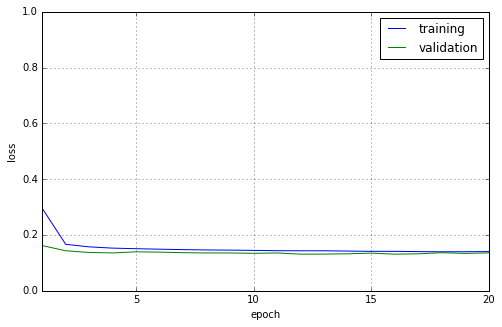

In [29]:
acc = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                    'training': history.history['loss'],
                    'validation': history.history['val_loss']})
ax = acc.ix[:,:].plot(x='epoch', figsize={5,8}, grid=True)
ax.set_ylabel("loss")
ax.set_ylim([0.0,1.0]);

In [30]:
min_val_loss, idx = min((val, idx) for (idx, val) in enumerate(history.history['val_loss']))
print 'Minimum loss at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(min_val_loss)

max_val_acc, idx = max((val, idx) for (idx, val) in enumerate(history.history['val_acc']))
print 'Maximum accuracy at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(max_val_acc)

Minimum loss at epoch 16 = 0.1313
Maximum accuracy at epoch 13 = 0.9515


In [31]:
model  = fmodel

if os.path.isfile(kfold_weights_path):
    print "loading best weights from '{}'".format(kfold_weights_path)
    model.load_weights(kfold_weights_path)
    
    

loading best weights from 'weights/res_sample_v1_exp.h5'


In [33]:
preds_val = model.predict(X_valid)


In [34]:
print('F2 Score:', f2_score(Y_valid, preds_val>0.08))

('F2 Score:', 0.85921643577888951)


In [35]:
thres = optimise_f2_thresholds(Y_valid, preds_val)
np.mean(thres)

(0, 0.01, 0.88342476812175308)
(1, 0.12, 0.88363016139812811)
(2, 0.06, 0.88378333405662957)
(3, 0.11, 0.88387958168252145)
(4, 0.19, 0.88395488067617467)
(5, 0.23, 0.88399417016597104)
(6, 0.18, 0.88421209095581998)
(7, 0.26, 0.88442481603267542)
(8, 0.11, 0.88442481603267542)
(9, 0.26, 0.88478311598798687)
(10, 0.21, 0.88497425087708437)
(11, 0.26, 0.88513192049993394)
(12, 0.12, 0.88518877789374784)
(13, 0.15, 0.88553796031668075)
(14, 0.21, 0.88568458370317571)
(15, 0.23, 0.88663136075087046)
(16, 0.07, 0.88782579380092297)


/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


0.16352941176470587

In [36]:
print('F2 Score:', f2_score(Y_valid, preds_val>thres))

('F2 Score:', 0.88782579380092297)


### Making Prediction

In [46]:
#clear memory
del x_train, X_train, X_valid, conv_trn_feat, conv_valid_feat
x_test = load_array("data/cache/xtest_100x100.dat")


In [45]:
oleg_test = load_array("data/cache/oleg_test")
oleg_test = oleg_test[:,2:]

In [47]:
mahotas_test = load_array("data/cache/mahotas_14_jpg_test.dat")

In [50]:
# preds = make_staged_predictions(x_test,num_parts=5,do_augmentation=False)
preds = make_staged_predictions_with_features(model=model,data=x_test, features=mahotas_test,num_parts=5,do_augmentation=False)

data has shape:  (61191, 3, 100, 100)
breaking data into chunks of  12238

predicting part  1

predicting part  2

predicting part  3

predicting part  4

predicting part  5

predicting part  6


In [51]:
save_array("data/cache/preds_vgg_and_mahotas_samples.dat",preds)

In [52]:
preds.shape, x_test.shape

((61191, 17), (61191, 3, 100, 100))

In [49]:

def make_staged_predictions_with_features(model, data,features,num_parts, do_augmentation=False):
    partial_preds = []
    nb_aug = 1

    vgg_common = create_base_vgg()
    vgg_common.compile(Adam(), 'categorical_crossentropy', metrics=['accuracy'])

    chunck_size = len(data)/num_parts

    print "data has shape: ", data.shape
    print "breaking data into chunks of ", chunck_size
    

    # do prediction on normal photos anyways
    for i in range(1,num_parts+2):
        print ""
        print "predicting part ",i
        
        start_index = (i-1)*chunck_size
        end_index = min(len(data),i*chunck_size)
        num_items = end_index-start_index
        
        
        
        vgg_test_feat = vgg_common.predict(data[start_index:end_index], batch_size=32, verbose=0)
        partial_preds.append(model.predict([vgg_test_feat,features[start_index:end_index]], batch_size=32, verbose=0))
        del vgg_test_feat   

    
    normal_image_preds = np.vstack(partial_preds)
    
    
    if not do_augmentation:
        return   normal_image_preds  

    
    
    else: ## test augmentation 
        augmented_predictions = normal_image_preds 
        for n in range(nb_aug):
            print ""
            print "augmentation round {} of {}".format(n+1,nb_aug) 
            partial_preds = []

            for i in range(1,num_parts+2):
                print ""
                print "predicting part {} of {}".format(i,num_parts)      
                
                start_index = (i-1)*chunck_size
                end_index = min(len(data),i*chunck_size)
                num_items = end_index-start_index
                
                
                test_batch = train_gen.flow(data[start_index:end_index],batch_size=16,shuffle=False)
                
                vgg_test_feat = vgg_common.predict_generator(test_batch, steps=math.ceil(num_items/16.0) ,verbose=1) 
                
#                 print ""
#                 print ("items needed vs. items generated: ",num_items,len(vgg_test_feat) )
                
                vgg_test_feat = vgg_test_feat[:num_items] #to make sure we only take as much as we need for this batch 
                
                partial_preds.append(model.predict(vgg_test_feat, batch_size=32, verbose=1))
                
                
            augmented_predictions += np.vstack(partial_preds)
            
        augmented_predictions /= (nb_aug+1) #including normal photo predictions
        return augmented_predictions

    
    


### K-fold cross validation

In [ ]:
thresholds = np.array(thresholds,np.float16)

In [28]:
print ("best val_loss has a mean of {} and stdev of {}".format(np.mean(val_errors), np.std(val_errors)))
print ("best val_acc has a mean of {} and stdev of {}".format(np.mean(val_accuracies), np.std(val_accuracies)))
print ("local best thresholds have a mean of {} and stdev of {}".format(thresholds.mean(), thresholds.std()))

1.699673171197595

In [22]:
np.save("data/cache/oof_vgg1.dat",oof_preds)
np.save("data/cache/10fold_crossvalidated_vgg1_test_preds.dat",yfull_test)

344080

In [ ]:
result = np.array(yfull_test[0])
for i in range(1, nfolds):
    result += np.array(yfull_test[i])
result /= nfolds
result = pd.DataFrame(result, columns = labels)
result

In [24]:
yfull_test[1].shape

(61191, 17)

In [47]:
t = np.array(yfull_test,np.float16)


array([[ 0.0005,  0.002 ,  0.0005, ...,  0.0012,  0.0168,  0.0013],
       [ 0.0002,  0.0005,  0.0006, ...,  0.0016,  0.0053,  0.0011],
       [ 0.0002,  0.0017,  0.    , ...,  0.0141,  0.0013,  0.0088],
       ..., 
       [ 0.0017,  0.0025,  0.0008, ...,  0.0056,  0.0091,  0.    ],
       [ 0.0031,  0.0036,  0.0037, ...,  0.0082,  0.0649,  0.2205],
       [ 0.0031,  0.0055,  0.0074, ...,  0.0086,  0.018 ,  0.0007]], dtype=float16)

In [50]:
t.shape

(2, 61191, 17)

In [54]:
t.mean(axis=0).shape


(61191, 17)

In [49]:
t.std(axis=0)

array([[ 0.0005,  0.002 ,  0.0005, ...,  0.0012,  0.0168,  0.0013],
       [ 0.0002,  0.0005,  0.0006, ...,  0.0016,  0.0053,  0.0011],
       [ 0.0002,  0.0017,  0.    , ...,  0.0141,  0.0013,  0.0088],
       ..., 
       [ 0.0017,  0.0025,  0.0008, ...,  0.0056,  0.0091,  0.    ],
       [ 0.0031,  0.0036,  0.0037, ...,  0.0082,  0.0649,  0.2205],
       [ 0.0031,  0.0055,  0.0074, ...,  0.0086,  0.018 ,  0.0007]], dtype=float16)

### Make submission

In [53]:
preds.shape

(61191, 17)

In [54]:
result = pd.DataFrame(preds, columns = labels)
result.head(1)

blow_down  bare_ground  conventional_mine  blooming  cultivation  \
0   0.001978     0.001438           0.000076    0.0178     0.003013   

   artisinal_mine      haze   primary  slash_burn  habitation     clear  \
0        0.000075  0.008281  0.997077    0.000203    0.002192  0.989675   

       road  selective_logging  partly_cloudy  agriculture     water    cloudy  
0  0.001708           0.001318        0.00322     0.007609  0.002989  0.001012

In [84]:
test_medians = result.median().values

In [88]:
# thres

In [90]:
test_medians - thres

array([-0.0394, -0.0884, -0.0196, -0.199 , -0.0506, -0.0496, -0.088 ,  0.2125, -0.0292, -0.027 ,
        0.1217, -0.0615, -0.1091, -0.0381, -0.044 , -0.0412, -0.0492])

In [71]:
tags_pred.shape,preds.shape

((17, 61191), (61191, 17))

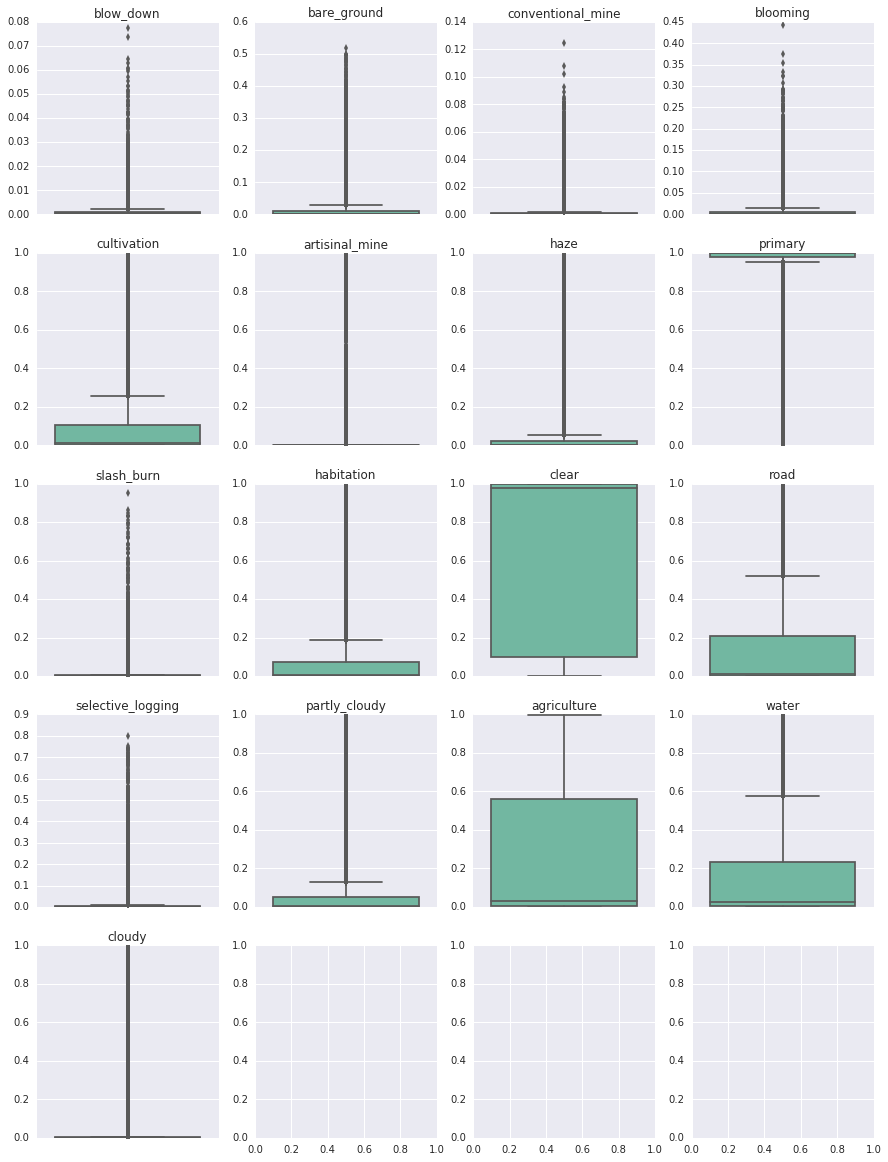

In [55]:
import seaborn as sns
tags_pred = np.array(preds).T
_, axs = plt.subplots(5, 4, figsize=(15, 20))
axs = axs.ravel()

for i, tag_vals in enumerate(tags_pred):
    sns.boxplot(tag_vals, orient='v', palette='Set2', ax=axs[i]).set_title(labels[i])


In [56]:
label_preds = []
for i in tqdm(range(result.shape[0]), miniters=1000):
    a = result.ix[[i]]
    a = a.apply(lambda x: x > thres, axis=1)
    a = a.transpose()
    a = a.loc[a[i] == True]
    ' '.join(list(a.index))
    label_preds.append(' '.join(list(a.index)))

100%|██████████| 61191/61191 [01:58<00:00, 514.36it/s]


In [57]:
df_test["tags"] = label_preds
df_test.head()

image_name                   tags
0     test_0          primary clear
1     test_1          primary clear
2     test_2  primary partly_cloudy
3     test_3          primary clear
4     test_4  primary partly_cloudy

In [60]:
submission_file = 'subm/vgg1_sample_plus_mahotas.csv'
df_test.to_csv(submission_file, index=False)
FileLink(submission_file)

/home/ubuntu/planet/subm/vgg1_sample_plus_mahotas.csv